**#Team F5- IPinsights algorithm to detect anomalies from web server logs**

## Introduction

The Amazon sage maker IP insights model captures correlation between Online resources (User Id and or hostnames) and IPv4 addresses by learning vector representations of them using statistical modelling and neural networks.

* The Amazon Web Services SDK for Python (Boto3) allows you to establish, configure, and administer AWS services including Amazon Elastic Compute Cloud (Amazon EC2) and Amazon Simple Storage Service (Amazon S3) 

* The SDK includes both an object-oriented API and low-level access to Amazon Web Services.
* The botocore package is the basis for boto3 and the AWS CLI, and it was built with the goal of increasing the use of Python in AWS.

In [1]:
#Importing Sagemaker related libraries
import boto3
import botocore
import os
import sagemaker
#Importing sagemaker SDK

In [2]:
storage = sagemaker.Session().default_bucket() 
#Our AWS account accesses this default storage S3 bucket

main_path = "AWSsagemaker/ipinsights-Team4" 
#Location in the bucket to store our output and Input

execution_role = sagemaker.get_execution_role() 
#IAM role that grants permissions

loc = boto3.Session().region_name 
#Referring to the region name the session is in

# check if the specified S3 bucket is present
try:
    boto3.Session().client("s3").head_bucket(Bucket=storage)
except botocore.exceptions.ParamValidationError as e:
    print("Check the parameter given in S3 bucket"
    )
except botocore.exceptions.ClientError as e:
    ec = e.response['Error']['Code']
    if ec == "404":
        print(f"Bucket {storage} doesn't exist")
    elif ec == "403":
        print(f"Forbidden to access the bucket, {storage}")
    else:
        raise
else:
    print(f"Please find the training output and input stored in the following location: s3://{storage}/{main_path}")

Please find the training output and input stored in the following location: s3://sagemaker-(aws region)-(AWS Account ID)/AWSsagemaker/ipinsights-Team4


Amazon S3 bucket instance has been created to store the training data and any other object belonging to the trained model. 

In [3]:
from os import path

storage_tools = f"jumpstart-cache-prod-{loc}"  
#The data generating module is contained in this bucket.

path_tools = "1p-algorithms-assets/ip-insights" 
# The data generating module's prefix

s3 = boto3.client("s3")


    
data_gen_file = "generate_data.py"  
# We can give our own synthetic data generation script here. In this case,
#we make use of the readily available script to generate simulated apache web server log data

ip2asn_file = "ip2asn-v4-u32.tsv.gz" 
#IP to ASN database file commonly used in similar IP address related
#machine learning 


#If data generation file is not available, it will download into the given location
if not path.exists(data_gen_file):
    print(f"data genfile path doesnt exist")
    s3.download_file(storage_tools, f"{path_tools}/{data_gen_file}", data_gen_file)

if not path.exists(ip2asn_file):
    print(f"ip2asn file path doesnt exist")
    s3.download_file(
        storage_tools, f"{path_tools}/{ip2asn_file}", ip2asn_file)
    


A dataset that mimics system traffic was created using a python script that generates random Apache web logs. 

In [4]:
#generating data 
from generate_data import generate_dataset
USER_COUNT = 1000
data_file = "simulated_ipinsights_webserver_traffic.log"
generate_dataset(USER_COUNT, data_file)


Loaded ASN List: 827696 ASNs.
Starting User Activity Simulation


100%|██████████| 1000/1000 [00:05<00:00, 190.23users/s]


Finished simulating web activity for 1000 users.


We can see the IP addresses each user has associated with by looking at the sample log output below:

In [5]:
# Visualize few log lines
!head $data_file

188.92.162.199 - user_0 [08/Nov/2018:20:58:23 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
188.92.100.68 - user_0 [05/Nov/2018:21:19:49 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
188.92.70.10 - user_0 [08/Nov/2018:07:34:07 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
188.92.133.70 - user_0 [06/Nov/2018:02:59:27 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/555.33 (KHTML, like Gecko) Chrome/1.1.1111.100 Safari/555.355"
188.92.136.39 - user_0 [13/Nov/2018:21:41:15 +0000] "GET /login_success HTTP/1.1" 200 476 "-" "Mozilla/5.0 (Macintosh; Intel Mac

Now the data generated needs to be transformed in to a way that is feasible to feed it to ip insights. 

In [6]:
import pandas as pd

#reading logs in to the dataframe and adding column names to it
data = pd.read_csv(
    data_file,
    na_values="-",
    sep=" ",
    header=None,
    names=[
        "user_ip_address", #IP address of the user who had accessed the server
        "rcf_id",
        "user_id", #ID of the user who had accessed the server
        "time_stamp",
        "timezone",
        "type_of_request",
        "response_status_code",
        "object_size", #object size sent to client
        "referer",
        "user_agent",
    ],
)


In [7]:
data.head()

,user_ip_address,rcf_id,user_id,time_stamp,timezone,type_of_request,response_status_code,object_size,referer,user_agent
0,188.92.162.199,NaN,user_0,[08/Nov/2018:20:58:23,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
1,188.92.100.68,NaN,user_0,[05/Nov/2018:21:19:49,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
2,188.92.70.10,NaN,user_0,[08/Nov/2018:07:34:07,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
3,188.92.133.70,NaN,user_0,[06/Nov/2018:02:59:27,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...
4,188.92.136.39,NaN,user_0,[13/Nov/2018:21:41:15,+0000],GET /login_success HTTP/1.1,200,476,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6...


In [8]:
#size of the dataset
data.shape

(277349, 10)

In [9]:
data[["time_stamp"]]

,time_stamp
0,[08/Nov/2018:20:58:23
1,[05/Nov/2018:21:19:49
2,[08/Nov/2018:07:34:07
3,[06/Nov/2018:02:59:27
4,[13/Nov/2018:21:41:15
...,...
277344,[13/Nov/2018:18:34:08
277345,[13/Nov/2018:02:05:13
277346,[09/Nov/2018:04:21:08
277347,[10/Nov/2018:14:00:52


To make it easier to sort and analyse the information, we transform the log timestamp strings to Python datetimes.

In [10]:
data["time_stamp"] = pd.to_datetime(data["time_stamp"], format="[%d/%b/%Y:%H:%M:%S")

In [11]:
#Make sure they're all in the same time zone.
count_timezones = len(data["timezone"].unique())
count_timezones

1

In [12]:
from datetime import datetime
import pytz


def transform_timezone(row):
    timez = row[1]
    timez_offset = int(timez[:3]) * 60  # Hour offset
    timez_offset += int(timez[3:5])  # Minutes offset
    return row[0].replace(timezinfo=pytz.FixedOffset(timez_offset))


In [13]:
if count_timezones > 1:
    data["time_stamp"] = data[["time_stamp", "timezone"]].apply(transform_timezone, axis=1)

The purpose of this design is to train the IP insights algorithm to predict the anomalous login events by analysing the user login history. 

1)To do that, first need to filter the GET requests where success code is 200 to select the successful user logins. 

In [14]:
data = data[(data["type_of_request"].str.startswith("GET /login_success")) & (data["response_status_code"] == 200)]

In [15]:
data = data[["user_id", "user_ip_address", "time_stamp"]]

In [16]:
data["time_stamp"].describe(datetime_is_numeric=True)

count                           277349
mean     2018-11-08 23:41:46.638508544
min                2018-11-04 00:00:02
25%                2018-11-06 11:29:05
50%                2018-11-08 23:43:29
75%                2018-11-11 11:35:17
max                2018-11-14 00:00:00
Name: time_stamp, dtype: object

11/04-11/10 marks the end of first 7 days of simulated logs and we will use it as train set. From 11/11 to 11/13 we use it for test set

2) Take the CSV file created and split the dataset into two adjacent sets where one for training and the other set for testing purpose.

In [17]:
time_window = (
    datetime(2018, 11, 11, timezinfo=pytz.FixedOffset(0))
    if count_timezones > 1
    else datetime(2018, 11, 11)
)

**Train-Test split**

In [18]:
train_data = data[data["time_stamp"] <= time_window]
test_data = data[data["time_stamp"] > time_window]


3)Take the training dataset and shuffle it to improve performance of the model then upload the training dataset to S3 bucket storage.

In [19]:
# Shuffling train data to improve performance of the model
train_data = train_data.sample(frac=1)
train_data.head()

,user_id,user_ip_address,time_stamp
1897,user_130,208.126.116.16,2018-11-09 15:20:25
111670,user_533,168.253.220.181,2018-11-04 11:21:51
46682,user_322,149.91.65.213,2018-11-09 13:19:55
68389,user_342,61.237.14.120,2018-11-06 02:37:14
191119,user_672,208.108.152.66,2018-11-10 15:56:50


### Store Data on S3

In [20]:
# Uploading train dataset as headerless CSV in S3 since IPInsights takes in a headerless CSV as input
train_data1 = train_data.to_csv(index=False, header=False, columns=["user_id", "user_ip_address"])

Configure the SageMaker IP Insights algorithm parameters and define the computational environment in the model. Then start training the model on training dataset stored in S3 bucket where successful completion of the training would store the output of IP insights model in the specified location.  

In [21]:
# Upload train data to S3 key
training_data1_file = "train.csv"
key = os.path.join(main_path, "train", training_data1_file)
s3_train_data = f"s3://{storage}/{key}"
print(f"Train Data {training_data1_file} uploading to this path: {s3_train_data}")
boto3.resource("s3").Bucket(storage).Object(key).put(Body=train_data1)
#SageMaker IP Insights Input Channels Configuration
input_data = {
    "train": sagemaker.session.s3_input(
        s3_train_data, distribution="FullyReplicated", content_type="text/csv"
    )
}


The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Train Data train.csv uploading to this path: s3://sagemaker-(aws region)-(AWS Account ID)/AWSsagemaker/ipinsights-Team4/train/train.csv


In [80]:
# create a headerless CSV file from the test dataset
test_data1 = test_data.to_csv(index=True, header=False, columns=["user_id", "user_ip_address"])

In [82]:
# Using S3 to store test data 
test_data1_file = "test.csv"
key = os.path.join(main_path, "test", test_data1_file)
s3_test_data = f"s3://{storage}/{key}"
print(f"Test data {test_data1_file} uploading to: {s3_test_data}")
boto3.resource("s3").Bucket(storage).Object(key).put(Body=test_data1)

Test data test.csv uploading to: s3://sagemaker-(aws region)-(AWS Account ID)/AWSsagemaker/ipinsights-Team4/test/test.csv


{'ResponseMetadata': {'RequestId': 'Q7ZDV7T46MADSZCA',
  'HostId': 'Ppyuu5mbfOTjJGh3b5kkPlABns1W4LJfo1Jn5mT4hVSi0MQB+5D1NhUrbHotGUj0911OWVkAF3w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Ppyuu5mbfOTjJGh3b5kkPlABns1W4LJfo1Jn5mT4hVSi0MQB+5D1NhUrbHotGUj0911OWVkAF3w=',
   'x-amz-request-id': 'Q7ZDV7T46MADSZCA',
   'date': 'Thu, 30 Sep 2021 09:06:36 GMT',
   'etag': '"d62278a0f454e38c185dddf8be26292d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d62278a0f454e38c185dddf8be26292d"'}

### Training

In [24]:
from sagemaker.amazon.amazon_estimator import get_image_uri

uri_image = get_image_uri(boto3.Session().region_name, "ipinsights") #container image used for the purpose of training

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [25]:
# Configuration of training job to set up the estimator
ip_insights = sagemaker.estimator.Estimator(
    uri_image,
    execution_role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    output_path=f"s3://{storage}/{main_path}/output",
    sagemaker_session=sagemaker.Session(),
)

# Configure hyperparameters of IPInsights algorithm
ip_insights.set_hyperparameters(
    num_entity_vectors="20000",
    random_negative_sampling_rate="5",
    vector_dim="128",
    mini_batch_size="1000",
    epochs="5",
    learning_rate="0.01",
)

# Starting the training job 
ip_insights.fit(input_data)

2021-09-29 01:50:16 Starting - Starting the training job...
2021-09-29 01:50:38 Starting - Launching requested ML instancesProfilerReport-1632880215: InProgress
......
2021-09-29 01:51:40 Starting - Preparing the instances for training.........
2021-09-29 01:53:07 Downloading - Downloading input data
2021-09-29 01:53:07 Training - Downloading the training image......
2021-09-29 01:54:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/29/2021 01:54:13 INFO 140101656037184] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'batch_metrics_publish_interval': '1000', 'epochs': '10', 'learning_rate': '0.001', 'mini_batch_size': '5000', 'num_entity_vectors': '100000', 'num_ip_encoder_layers': '1', 'random_negative_sampling_rate': '1', 'shuffled_negative_sampling_rate': '1', 'vector_dim': '128', 'weight_decay

The trained model would be deployed to an endpoint to start making predictions on data. 
This model predicts outputs as a dot product of the learned IP address and the user ID where this output gives the compatibility between the IP address and the user ID. 
The higher the output value is the more IP address matches with the user ID. 
But in order to consider a user login as anomalous, a threshold has to be defined. 
If the dot product is above threshold value, the user login is a suspicious login attempt to the website. 
The action of defining a good threshold depends on the dataset, the problem specification, or the requirement of the system user.  

### **Deploying to Endpoint**
- For performing an inference on the data, we have to deploy the model to an end point which refers to predicting the dot product score/compatibility score if user id and ip address are given
- Here we will create an inference endpoint using deploy() function
- This inference endpoint will be used to integrate with other services in order to accomplish our goal


In [26]:
predictor = ip_insights.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

-------------!

In [27]:
print(f"Endpoint name: {predictor.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: ipinsights-2021-09-29-01-56-38-227


## Data Serialization/Deserialization

* **Passing csv data to inference endpoint and configuring the inference endpoint using csv_serializer and json_deserializer** *

In [28]:
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

- Passing a matrix of inference data to the predictor to predict
the dot product which outlines the amount of compatibility between the online resource and IP Address
- A higher dot product value shows the user is more likely to use the identified IP Address.


In [59]:
inference_data = [(data[0], data[1]) for data in train_data[:5].values]
predictor.predict(
    inference_data, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 3.6569502353668213},
  {'dot_product': 2.9151065349578857},
  {'dot_product': 4.475464344024658},
  {'dot_product': 5.48666524887085},
  {'dot_product': 2.4879698753356934}]}

In [84]:
inference_data = [(data[0], data[1]) for data in test_data[:5].values]
predictor.predict(
    inference_data, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 0.6415402293205261},
  {'dot_product': 0.5958351492881775},
  {'dot_product': 0.6833871006965637},
  {'dot_product': 0.6415402293205261},
  {'dot_product': 0.6415402293205261}]}

In [65]:
inference_data = [(data[0], data[1]) for data in test_data.values]
test_scores = predictor.predict(
    inference_data, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [66]:
test_scores_df = pd.DataFrame(test_scores)

In [71]:
# Uploading test score data as headerless CSV in S3 since IPInsights takes in a headerless CSV as input
test_scores1 = test_scores_df.to_csv(index=False,header=False)

In [72]:
# Upload test data to S3 key
test_scores1_file = "test_scores.csv"
key = os.path.join(main_path, "test_data_scores", test_scores1_file)
s3_test_score_data = f"s3://{storage}/{key}"
print(f"Test score data {test_scores1_file} uploading to: {s3_test_score_data}")
boto3.resource("s3").Bucket(storage).Object(key).put(Body=test_scores1)

Test score data test_scores.csv uploading to: s3://sagemaker-(aws region)-(AWS Account ID)/AWSsagemaker/ipinsights-Team4/test_data_scores/test_scores.csv


{'ResponseMetadata': {'RequestId': '1826372XV8S2JECB',
  'HostId': 'TnUpVFqEG1384EGGdReKAP+hwj0So5fRSxLMo2KZkzz9OYRuzXSP9DCeP36Qjiyd+BUrxJcF6OQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'TnUpVFqEG1384EGGdReKAP+hwj0So5fRSxLMo2KZkzz9OYRuzXSP9DCeP36Qjiyd+BUrxJcF6OQ=',
   'x-amz-request-id': '1826372XV8S2JECB',
   'date': 'Thu, 30 Sep 2021 08:44:30 GMT',
   'etag': '"1bdf044838e89661d63e549b9370fc7b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1bdf044838e89661d63e549b9370fc7b"'}

Only the dot product between the learnt IP address and the user ID will be reported by the predictor. The dot product summarises the IP address and online resource compatibility. The higher the value, the more probable the IP address will be utilised by the user, according to the algorithm.Because we can specify a threshold for what we consider an abnormal score, this compatibility score is adequate for most applications.

In [30]:
predictor.predict(
    inference_data,
    initial_args={"ContentType": "text/csv", "Accept": "application/json; verbose=True"},
)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 3.6569502353668213,
   'ip_embedding': [0.3658466339111328,
    0.48375773429870605,
    0.5376017689704895,
    -0.29106229543685913,
    0.19438119232654572,
    1.1738483905792236,
    0.003845706582069397,
    -0.00765864085406065,
    0.2954220771789551,
    -0.08345441520214081,
    0.020668014883995056,
    0.03261309117078781,
    -0.7328222990036011,
    -0.03141923248767853,
    -0.03552141785621643,
    -0.7716969847679138,
    -0.8599123358726501,
    0.9044795036315918,
    -0.6965539455413818,
    -0.10196264088153839,
    -0.21765917539596558,
    -0.008940439671278,
    -0.057777080684900284,
    0.08945049345493317,
    0.4317513704299927,
    0.3527544140815735,
    -0.06586072593927383,
    0.102727010846138,
    -0.1025468111038208,
    0.43525731563568115,
    -1.063232421875,
    0.5312546491622925,
    0.7790141701698303,
    0.21645663678646088,
    0.6006211638450623,
    0.28559625148773193,
    -0.42113983631134033,
    -0.221

### Compute Anomaly Scores

- Since the dot product's range is unbounded, we will have to set a threshold to flag an event as anomolous
- In order to detect and compute anomaly score if the dot_product is above the threshold we can flag it as anomolous behavior. In order to do this we will compare the score distributions between known normal and malicious traffic to select a threshold.
- However, to select an appropriate threshold, first take the test dataset created before and consider it as the ‘Normal’ traffic. 
- Then to stimulate an attacker login using a user ID belonging to that website but with a different IP address, take few user IDs from the test dataset, couple it with randomly generated IP addresses and inject them to the test dataset as the ‘Malicious’ traffic. 
- Then plot the distribution of normal traffic and malicious traffic using the dot product scores generated by the model and select a threshold value that separates the normal traffic and malicious traffic.

In [83]:
## Construct 'Normal' Traffic Dataset

test_data.head()

,user_id,user_ip_address,time_stamp
4,user_0,188.92.136.39,2018-11-13 21:41:15
11,user_0,188.92.161.125,2018-11-13 19:50:22
20,user_0,188.92.161.31,2018-11-13 04:49:29
29,user_0,188.92.221.52,2018-11-13 11:30:44
34,user_0,188.92.240.129,2018-11-13 19:26:20


- Here we will simulate some malicious traffic which replicates a scenario of cyber attack
- To simulate a hacker logging into an account with no knowledge of their IP history, we pick a random set of accounts
from test data and generate random IP addresses. This will make these events malicious

In [32]:
## Injection of Malicious Traffic

import numpy as np
from generate_data import draw_ip


def score_ip_insights(predictor, data):
    def get_score(result):
        """Return the negative to the dot product of the predictions from the model."""
        return [-prediction["dot_product"] for prediction in result["predictions"]]

    data = data[["user_id", "user_ip_address"]]
    result = predictor.predict(data.values)
    return get_score(result)

def create_test_case(train_data, test_data, num_samples, attack_freq):
    
    # Get as many accounts as you can. Only users who have been seen in training can be predicted by the IP Insights model. 
    # As a result, remove any accounts that have never been viewed from the test sample, as their findings will be meaningless.
    valid_accounts = set(train_data["user_id"])
    valid_test_df = test_data[test_data["user_id"].isin(valid_accounts)]

    clean_traffic = valid_test_df.sample(num_samples, replace=False)
    clean_traffic = clean_traffic[["user_id", "user_ip_address"]]
    clean_traffic["label"] = 0
    # Generating anomalous traffic
    num_malicious_traffic = int(num_samples * attack_freq)
    malicious_traffic_accounts = np.random.choice(
        list(valid_accounts), size=num_malicious_traffic, replace=True
    )
    malicious_traffic_ips = [draw_ip() for i in range(num_malicious_traffic)]
    malicious_traffic = pd.DataFrame({"user_id": malicious_traffic_accounts, "user_ip_address": malicious_traffic_ips})
    malicious_traffic["label"] = 1

    # All traffic labels are in the format: 0 for legitimate traffic; 1 for malicious traffic.
    all_traffic = clean_traffic.append(malicious_traffic)

    return all_traffic


In [33]:
NUMBER_OF_SAMPLES = 1000
test_case = create_test_case(train_data, test_data, num_samples=NUMBER_OF_SAMPLES, attack_freq=1)
test_case.head()

,user_id,user_ip_address,label
108984,user_526,43.251.151.62,0
75220,user_352,223.194.109.77,0
106335,user_526,14.194.240.254,0
205294,user_609,223.223.170.228,0
181300,user_783,120.140.192.17,0


In [55]:
test_case

,user_id,user_ip_address,label
108984,user_526,43.251.151.62,0
75220,user_352,223.194.109.77,0
106335,user_526,14.194.240.254,0
205294,user_609,223.223.170.228,0
181300,user_783,120.140.192.17,0
...,...,...,...
995,user_459,192.5.30.187,1
996,user_478,91.93.206.88,1
997,user_468,40.189.168.177,1
998,user_894,91.187.109.95,1


In [34]:
scores_test_case = score_ip_insights(predictor, test_case)
scores_test_case

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


[-4.361762523651123,
 -1.6980564594268799,
 -5.355741500854492,
 -7.396884441375732,
 -4.967178821563721,
 -7.738031387329102,
 -3.1108298301696777,
 -2.2000064849853516,
 -3.4068431854248047,
 -5.375384330749512,
 -4.592621326446533,
 -3.3712990283966064,
 -6.461093902587891,
 -6.057474136352539,
 -6.452129364013672,
 -2.4910950660705566,
 -3.752969741821289,
 -3.9644289016723633,
 -5.157312870025635,
 -0.6461054682731628,
 -3.979700803756714,
 -4.720238208770752,
 5.577888488769531,
 -2.698194980621338,
 -6.0456318855285645,
 -2.5118627548217773,
 2.9032058715820312,
 -5.496243953704834,
 -4.737061977386475,
 -3.782761573791504,
 -3.0034658908843994,
 -6.230874538421631,
 -3.3194174766540527,
 -2.758659839630127,
 -3.215980291366577,
 -3.2690396308898926,
 -4.70637845993042,
 -1.8449420928955078,
 -3.558104991912842,
 -4.378335952758789,
 -3.7895259857177734,
 -4.744161605834961,
 -2.056386947631836,
 -4.098066329956055,
 -3.9102041721343994,
 -2.942593574523926,
 -3.367490291595459,

### Plot Distribution

Let's plot the distribution of scores. This distribution will show us where, we should establish a reasonable threshold.

<Figure size 432x288 with 0 Axes>

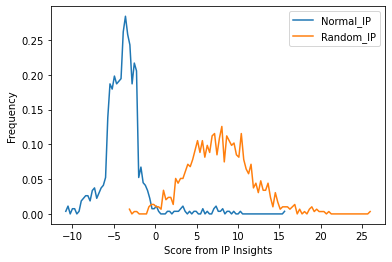

<Figure size 432x288 with 0 Axes>

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

a, b = np.histogram(scores_test_case[:NUMBER_OF_SAMPLES], bins=100, density=True)
plt.plot(b[1:], a)

a, b = np.histogram(scores_test_case[NUMBER_OF_SAMPLES:], bins=100, density=True)
plt.plot(b[1:], a)

plt.legend(["Normal_IP", "Random_IP"])
plt.xlabel("Score from IP Insights")
plt.ylabel("Frequency")

plt.figure()

### Threshold value setup
We will select threshold as 0 to catch more true positives based on business impact. We can change it to whatever we want.If the system is more responsive to false positive decisions, the threshold can be set to a value such as 10.0 which detects the login attempt as high suspicious.


In [38]:
threshold = 0.0

flag_cases = test_case[np.array(scores_test_case) > threshold]

num_flag_cases = len(flag_cases)
true_positives = len(flag_cases[flag_cases["label"] == 1])
false_positives = len(flag_cases[flag_cases["label"] == 0])
all_positives = len(test_case.loc[test_case["label"] == 1])

print(f"Threshold that was set: {threshold}")
print(f"Number of cases flagged : {num_flag_cases}")
print(f"Flagged True positive cases : {true_positives}")
print(f"True Positive Rate: {true_positives / float(num_flag_cases)}")
print(f"Recall: {true_positives / float(all_positives)}")
print(f"Precision: {true_positives / float(num_flag_cases)}")

Threshold that was set: 0.0
Number of cases flagged : 1019
Flagged True positive cases : 984
True Positive Rate: 0.9656526005888125
Recall: 0.984
Precision: 0.9656526005888125


# **Amazon Sagemaker Automatic Model Tuning**

- To automate finding the process of best hyperparameters, we can use Amazon Sagemaker Automatic Model Tuning.
- If we get to use the same test dataset for best model selection, we might end up being biased.
- The test data is split as validation dataset and test dataset where model selection is done using validation dataset. 

In [39]:
#Splitting test set and validation set
validation_split = (
    datetime(2018, 11, 13, tzinfo=pytz.FixedOffset(0))
    if count_timezones > 1
    else datetime(2018, 11, 13)
)

validation_df = test_data[test_data["time_stamp"] < validation_split]
test_data = test_data[test_data["time_stamp"] >= validation_split]

valid_final_data = validation_df.to_csv(index=False, header=False, columns=["user_id", "user_ip_address"])

In [41]:
# Data should be uploaded to an S3 key.
valdata_csvfile = "valid.csv"
key = os.path.join(main_path, "validation", valdata_csvfile)
boto3.resource("s3").Bucket(storage).Object(key).put(Body=valid_final_data)
s3_valid_final_data = f"s3://{storage}/{key}"

print(f"Uploaded the final validation data in S3 to: {s3_valid_final_data}")

# Configuring validation input channels for IP Insights
input_data = {"train": s3_train_data, "validation": s3_valid_final_data}

Uploaded the final validation data in S3 to: s3://sagemaker-(aws region)-(AWS Account ID)/AWSsagemaker/ipinsights-Team4/validation/valid.csv


In [42]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter

# Configuring autotuner HyperparameterTuner
ipins_autotuner = HyperparameterTuner(
    estimator=ip_insights,  # previously-configured Estimator object
    objective_metric_name="validation:discriminator_auc",
    hyperparameter_ranges={"vector_dim": IntegerParameter(64, 1024)},
    max_jobs=4,
    max_parallel_jobs=2,
)

# Begin the hyperparameter tweaking process.
ipins_autotuner.fit(input_data, include_cls_metadata=False)

......................................................................................................................................!


In [43]:

ipins_autotuner.wait() # This code makes the auto tuner to Wait for all jobs to complete

# Visualize the outcomes of training
ipins_autotuner.analytics().dataframe()

!


,vector_dim,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,97.0,ipinsights-210929-0211-004-baaa2e4b,Completed,0.991139,2021-09-29 02:19:53+00:00,2021-09-29 02:21:54+00:00,121.0
1,840.0,ipinsights-210929-0211-003-dcfb94a5,Completed,0.988193,2021-09-29 02:19:28+00:00,2021-09-29 02:22:12+00:00,164.0
2,758.0,ipinsights-210929-0211-002-4931b5fe,Completed,0.989043,2021-09-29 02:14:37+00:00,2021-09-29 02:17:04+00:00,147.0
3,113.0,ipinsights-210929-0211-001-642b66c9,Completed,0.991078,2021-09-29 02:14:18+00:00,2021-09-29 02:16:55+00:00,157.0


In [44]:
# Deploying best model selected by autotuner
best_autotuned_predictor = ipins_autotuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=csv_serializer,
    deserializer=json_deserializer,
)


2021-09-29 02:21:54 Starting - Preparing the instances for training
2021-09-29 02:21:54 Downloading - Downloading input data
2021-09-29 02:21:54 Training - Training image download completed. Training in progress.
2021-09-29 02:21:54 Uploading - Uploading generated training model
2021-09-29 02:21:54 Completed - Training job completed
------!

In [45]:
# prediction based on the SageMaker endpoint
best_autotuned_predictor.predict(
    inference_data, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'dot_product': 2.4384820461273193},
  {'dot_product': 3.976551055908203},
  {'dot_product': 3.737670660018921},
  {'dot_product': 7.147300720214844},
  {'dot_product': 4.389705181121826}]}

From the training task, we ought to have the top performing model.Just the same as we did with the inference endpoint above, we now can set thresholds and predict outcomes.
We'll be allowed to use this better model to set a threshold and make predictions based on an input.

# **BATCH TRANSFORM**

- Batch transforms removes noise and bias that comes with any inference or training from our data
- Inferences from large datasets like log files are obtained from Batch transform 
- We wil be taking the existing training job and evaluate it on the validation data in S3 bucket

In [46]:
batch_transf = ip_insights.transformer(instance_count=1, instance_type="ml.m5.xlarge")

batch_transf.transform(s3_valid_final_data, content_type="text/csv", split_type="Line")

.............................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[09/29/2021 02:32:34 INFO 140355974801216] loaded entry point class algorithm.serve.server_config:config_api
[09/29/2021 02:32:34 INFO 140355974801216] loading entry points
[09/29/2021 02:32:34 INFO 140355974801216] Loaded iterator creator application/x-ndarray for content type ('application/x-ndarray', '1.0')
[09/29/2021 02:32:34 INFO 140355974801216] Loaded iterator creator text/csv for content type ('text/csv', '1.0')
[09/29/2021 02:32:34 INFO 140355974801216] loaded request iterator application/json
[09/29/2021 02:32:34 INFO 140355974801216] loaded request iterator application/jsonlines
[09/29/2021 02:32:34 INFO 140355974801216] loaded request iterator text/csv
[09/29/2021 02:32:34 INFO 140355974801216] loaded response encoder application/json
[09/29/2021 02:32

In [47]:
# Wait for the Transform Job to complete
batch_transf.wait()

Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[09/29/2021 02:32:34 INFO 140355974801216] loaded entry point class algorithm.serve.server_config:config_api
[09/29/2021 02:32:34 INFO 140355974801216] loading entry points
[09/29/2021 02:32:34 INFO 140355974801216] Loaded iterator creator application/x-ndarray for content type ('application/x-ndarray', '1.0')
[09/29/2021 02:32:34 INFO 140355974801216] Loaded iterator creator text/csv for content type ('text/csv', '1.0')
[09/29/2021 02:32:34 INFO 140355974801216] loaded request iterator application/json
[09/29/2021 02:32:34 INFO 140355974801216] loaded request iterator application/jsonlines
[09/29/2021 02:32:34 INFO 140355974801216] loaded request iterator text/csv
[09/29/2021 02:32:34 INFO 140355974801216] loaded response encoder application/json
[09/29/2021 02:32:34 INFO 140355974801216] loa

In [48]:
print(f"O/P for batch transform is in this path {batch_transf.output_path}")

O/P for batch transform is in this path s3://sagemaker-(aws region)-(AWS Account ID)/ipinsights-2021-09-29-02-27-55-552


## References

- Engdahl, S. (2008). Blogs. Amazon. Retrieved September 21, 2021, from https://aws.amazon.com/blogs/machine-learning/detect-suspicious-ip-addresses-with-the-amazon-sagemaker-ip-insights-algorithm/. 
- AWS SDK for python (boto3) documentation - docs.aws.amazon.com. (n.d.). Retrieved October 21, 2021, from https://docs.aws.amazon.com/pythonsdk/. 